# Scraping www.boligportalen.dk and predicting housing rents

There are so many houses being rented today. Through many different pages. Especially in the big cities everyone wants to get a nice place to live. With huge demand there is a chance that people who rent out their places might raise prices to a critical point. This is not very good. So i wondered if there were any way to calculate what at fair rent is for a house. Machine learning to the rescue! In this notebook I have scraped one of the largest danish sites for renting out houses and tried to predict the cost of rental.

In [19]:
#Import packages:
import re
from bs4 import BeautifulSoup
import requests 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from IPython.core.display import Image
import time
import selenium
from selenium import webdriver
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from sklearn.metrics import mean_squared_error
import folium
import geopandas as gpd
import fiona
import shapely
import os
import requests
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
# Inititate webdriver
driver = webdriver.Firefox(executable_path=r'/Users/jonathanmarin/Desktop/bolig/geckodriver')

def render_page(url):
    # This function uses firefox webdriver to scrape the HTML-source code from boligportalen
    # We need to do this because the page is dynamically generated
    driver.get(url)
    # Makes the code wait for a few seconds in order for page to load properly
    time.sleep(2)
    # Get entire page source
    r = driver.page_source
    return(r)

def remove_html_tags(text):
    # Functon to clean HTML-code
    clean = re.compile('<.*?>')
    return(re.sub(clean, '', text))

### Scrape main pages from boligportalen

Boligportalen is made up of a list of pages that each consists a number of different houses. We first need to scrape the source code from each of these sites

In [21]:
# Generate the list of main page links
main_page_links = []

# Remember to select the number of pages to scrape in range_function
for i in range(2,100,2):
    page = "https://www.boligportal.dk/find?startRecord=NUMBER0"
    pages = page.replace("NUMBER", str(i))
    main_page_links.append(pages)

### Get HTML-code for each main page 

In [22]:
# Empty vector to store HTML
html_code = []

# Loop through main pages, render them and extract code
for i in main_page_links: 
    html = render_page(i)
    soup = BeautifulSoup(html, "html.parser")
    html_code.append(soup)

In [23]:
# Now get the links to the houses. The links are stored inder itemprops as href's attributes
temp_house_links = []
final_house_links = []

for i in html_code:
    for span in i.findAll('a', itemprop="url"):
        temp_house_links.append(span.attrs['href'])
        
# We need to append "https://www.boligportalen.dk" to the start of all links
for i in temp_house_links:
    link = "https://www.boligportal.dk" + i
    final_house_links.append(link)

### Get HTML-code for each sub-page and extract relevant information about the houses

In [ ]:
# Loop over all pages of houses and get HTML-code
houses_html_code = []
housing_data = []
address = []

# Loop through main pages, render them and extract code
for i in final_house_links: 
    html = render_page(i)
    soup = BeautifulSoup(html, "html.parser")
    houses_html_code.append(soup)

# Quit the driver
driver.quit()

In [ ]:
# Define data containers
adresse = []
boligtype = []
størrelse= []
værelser= []
etage= []
møbleret= []
delevenlig= []
husdyr_tilladt= []
energimærke= []
lejeperiode= []
overtagelsesdato= []
månedlig_leje= []
aconto= []
depositum= []
forudbetalt_leje= []
indflytningspris= []
oprettelsesdato= []

# Find all relevant data and append to respective vectors above
for i in houses_html_code:
    for span_1 in i.findAll('h2', {"class": "AdDetail__header-heading-sub"}):
        adresse.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[0]:
        boligtype.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[1]:
        størrelse.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[2]:
        værelser.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[3]:
        etage.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[4]:
        møbleret.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[5]:
        delevenlig.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[6]:
        husdyr_tilladt.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[7]:
        energimærke.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[8]:
        lejeperiode.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[9]:
        overtagelsesdato.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[10]:
        månedlig_leje.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[11]:
        aconto.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[12]:
        depositum.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[13]:
        forudbetalt_leje.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[14]:
        indflytningspris.append(remove_html_tags(str(span_1)))
    for span_1 in i.findAll('span', {"class": "AdFeatures__item-value"})[15]:
        oprettelsesdato.append(remove_html_tags(str(span_1)))

### Cleaning data and storing it in a dataframe

In [8]:
# Convert raw data to dataframe
df = pd.DataFrame({"adresse": adresse,
                   "boligtype": boligtype,
                   "størrelse": størrelse, 
                   "værelser": værelser,
                   "etage": etage,
                   "møbleret": møbleret,
                   "delevenlig": delevenlig,
                   "husdyr_tilladt": husdyr_tilladt,
                   "energimærke": energimærke,
                   "lejeperiode": lejeperiode,
                   "overtagelsesdato": overtagelsesdato,
                   "månedlig_leje": månedlig_leje,
                   "aconto": aconto,
                   "depositum": depositum,
                   "forudbetalt_leje": forudbetalt_leje,
                   "indflytningspris": indflytningspris,
                   "oprettelsesdato": oprettelsesdato})

In [5]:
# Remove all unwanted notation from respective variables 
df["depositum"] = pd.to_numeric(df["depositum"].str.replace('[^\w\s]',''))
df["aconto"] = pd.to_numeric(df["aconto"].str.replace('[^\w\s]',''))
df["forudbetalt_leje"] = pd.to_numeric(df["forudbetalt_leje"].str.replace('[^\w\s]',''))
df["indflytningspris"] = pd.to_numeric(df["indflytningspris"].str.replace('[^\w\s]',''))
df["månedlig_leje"] = pd.to_numeric(df["månedlig_leje"].str.replace('[^\w\s]',''))
df["størrelse"] = pd.to_numeric(df["størrelse"].str.replace(' m²',''))

# Recode "overtagelsesdato"
new = []
for i in df["overtagelsesdato"]:
    if i == "Snarest":
        new.append("snarest")
    else: 
        new.append("ikke snarest")
df['overtagelsesdato'] = new

# Clean address column
new_1 = []
sep = '-'
for i in df["adresse"]:
    rest = i.split(sep, 1)[0]
    #rest = rest.replace('ø', 'oe')
    #rest = rest.replace('Ø', 'oe')
    new_1.append(rest)
df['adresse'] = new_1

df = df.drop(['energimærke'], axis=1)

# Inspect dataframe
df.head()

,aconto,adresse,boligtype,delevenlig,depositum,etage,forudbetalt_leje,husdyr_tilladt,indflytningspris,lejeperiode,månedlig_leje,møbleret,oprettelsesdato,overtagelsesdato,størrelse,værelser
0,680.0,"Schleppegrellsgade, 9000 Aalborg",Lejlighed,Nej,17250,2. sal,5750.0,Nej,29430,Ubegrænset,5750,Nej,29/10-2018,snarest,65,2
1,200.0,"Brassøvej, 8240 Risskov",Lejlighed,Ja,33585,2. sal,11195.0,Nej,56175,Ubegrænset,11195,Nej,12/06-2018,ikke snarest,82,4
2,500.0,"Engtoftevej, 9000 Aalborg",Lejlighed,Nej,19500,stuen,0.0,Nej,26500,Ubegrænset,6500,Nej,24/10-2018,snarest,66,2
3,900.0,"Rørsangervej, 3650 Ølstykke",Lejlighed,Nej,26985,1. sal,8995.0,Nej,45875,Ubegrænset,8995,Nej,25/10-2018,ikke snarest,140,4
4,1000.0,"Søndergade, 6270 Tønder",Lejlighed,Ja,16500,stuen,0.0,Nej,23000,Ubegrænset,5500,Nej,03/09-2018,snarest,100,3


### Geolocating house addresses

In [63]:
# Initialize geolocator (timeout makes sure that the connection to server does not return time out error)
geolocator = Nominatim()

lon = []
lat = []

address = list(df["adresse"])

# Geolocating
for i in address: 
    location = geolocator.geocode(str(i))
    if location:
        lon.append(location.longitude)
        lat.append(location.latitude)
    else:
        lon.append(np.NaN)
        lat.append(np.NaN)

# Append results to dataframe
df["longitude"] = pd.to_numeric(lon)
df["latitude"] = pd.to_numeric(lat)

In [2]:
# Save as excel file: 
#writer = pd.ExcelWriter('bolig_scrape1.xlsx')
#df.to_excel(writer,'Sheet1')
#writer.save()
df = pd.read_excel("bolig_scrape1.xlsx")
df.head()

,aconto,adresse,boligtype,delevenlig,depositum,etage,forudbetalt_leje,husdyr_tilladt,indflytningspris,lejeperiode,månedlig_leje,møbleret,oprettelsesdato,overtagelsesdato,størrelse,værelser,longitude,latitude
0,NaN,"Cortex Park, 5230 Odense M",Lejlighed,Ja,22500,1. sal,NaN,Nej,30000,Ubegrænset,7500,Nej,24/08-2018,snarest,72,2,10.430741,55.374059
1,520.0,"Holbergsgade, 9000 Aalborg",Lejlighed,Nej,27600,2. sal,9200.0,Nej,46520,Ubegrænset,9200,Nej,23/10-2018,ikke snarest,102,3,9.914872,57.050140
2,NaN,"Svalegangen, 9380 Vestbjerg",Lejlighed,Nej,25050,-,8350.0,Ja,41750,Ubegrænset,8350,Nej,20/02-2017,ikke snarest,116,5,9.954894,57.137212
3,0.0,"Klostergade, 7770 Vestervig",Lejlighed,Ja,9300,1. sal,0.0,Ja,12400,Ubegrænset,3100,Nej,28/09-2018,snarest,70,3,8.320781,56.762740
4,880.0,"Fyensgade, 9000 Aalborg",Lejlighed,Nej,22485,2. sal,7495.0,Nej,38355,Ubegrænset,7495,Nej,25/10-2018,snarest,95,3,9.937992,57.042563


### Visualizing the data

Let's visualize some data! First off, it is interesting to see where houses with highest and lowest rental prices are located. The plot beneath shows this. Suprisingly, the most expensive rentals appear to be in the larger cities... You can zoom in on the map and find the locations in each city where rentals tend to be highest!

In [3]:
# First, let's make a plot over house prices
map_data = df.dropna()

# Specify maximum for plot
maximum = float(map_data['månedlig_leje'].max())

# Set map location
dk_map = folium.Map(location=[56, 11.5], zoom_start=7.5, )

# Create and plot map
heatmap = HeatMap(list(zip(map_data.latitude.values, map_data.longitude.values, map_data.månedlig_leje.values)),
                   min_opacity=0.6,
                   max_val=maximum,
                   radius=17, blur=15, 
                   max_zoom=10, 
                 )
dk_map.add_child(heatmap)

### Interpolating house prices

Interpolating is done by using the data on houses in our dataset to predict house prices on all regions in Denmark. In short, I train a machine learning model on this data to predict rental prices based on house locations. I then use this model to predict house prices for all locations (coordinates) in Denmark.

Let's start by reading a shapefile of Denmark and restricting the area to zealand only. Thisis beacuse of computational issues. Rendering all of DK takes too long time.

In [10]:
# Get shapefile of Denmark and create east north coordinate bounds
data = gpd.read_file("KOMMUNE.shp")

# Restric to zealand 
d = {'Region Hovedstaden': True, 'Region Sjælland': True}
data["first"] = data['REGIONNAVN'].map(d)
data["first"] = data["first"].fillna(False)

c = {'Bornholm': False, 'Christiansø': False}
data["second"] = data['KOMNAVN'].map(c)
data["second"] = data["second"].fillna(True)

data['combined'] = data.apply(lambda x: True if x['first'] == True & x['second'] == True else False, axis=1)

# Caclulate bounds of zealand for creating grid
bounds_zealand = data[(data['combined'] == True)]
bounds = bounds_zealand.total_bounds

Now we can project our houses locations to coordinates and append these to our dataset

In [11]:
# Y is east coordinates and x north coordinates. Combining these into a 2d np.array with the np.vstack function
dist=500
y, x = grid_points = np.mgrid[bounds[1]:bounds[3]:dist, bounds[0]:bounds[2]:dist]

x_flat = x.flatten()
y_flat = y.flatten()
combined = np.vstack((x_flat, y_flat)).T

# Convert lon lat to east north coordinate
import pyproj as proj

crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj(init='epsg:23032') # use a locally appropriate projected CRS(here its denmark https://epsg.io/23032)

# Cast geographic coordinate pair to the projected system
lon = list(df["longitude"])
lat = list(df["latitude"])
y, x = proj.transform(crs_wgs, crs_bng, lon, lat)

# Append to dataframe. Now we have all the data needed to interpolate our prices geospatially
df["east"] = y
df["north"] = x

The next step is interpolating house prices. Fitting a KNN model with house coordinates as features and rentals as label

In [12]:
# Prepare data for machine learning - Including only East and North coordinates and removing NaN's
df_interpolate = df.copy()
df_interpolate.replace([np.inf, -np.inf], np.nan)
df_interpolate = df_interpolate.dropna()
df_interpolate = df_interpolate[['månedlig_leje','east', "north"]]

# Splitting data into feature and label data
X = df_interpolate.drop(["månedlig_leje"], axis=1).values
Y = df_interpolate["månedlig_leje"].values

# Fitting a KNN regressor to the data
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=25, radius=50000)
neigh.fit(X, Y) 

# Using the KNN regressor to fit the Zealand grid data:
c = neigh.predict(combined)

# The prediction outputs a 1d-array that can be stored in a data frame
house_estimates1 = pd.DataFrame(c)
house_estimates1.columns = ["interpolated_price"]

# Combine interpolations with corresponding coordinates
combined = pd.DataFrame(combined)
combined.columns = ['e', 'n']
house_estimates = pd.concat([combined, house_estimates1], axis=1)

Define function to project coordinates to polygons

In [13]:
from shapely.geometry import box

dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    
    def _to_square_polygon(row):
        d = dist/2
        poly = box(row[x]-d, row[y]-d, row[x]+d, row[y]+d)  
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

Converting interpolated prices to polygons and calculating the intersection between coordiantes in zealand and the grid of zealand

In [ ]:
# Convert to polygons 
data_new = cell_coords_to_polygons(house_estimates, x='e', y='n', dist=500, crs=dk_crs)
print("The data has been converted to polygons!")

# Calculate spatial intersections
intersection = gpd.overlay(data_new, bounds_zealand, how="intersection")
print("The intersection has been calculated!")

The data has been converted to polygons!


Creating plot of prices on zealand!

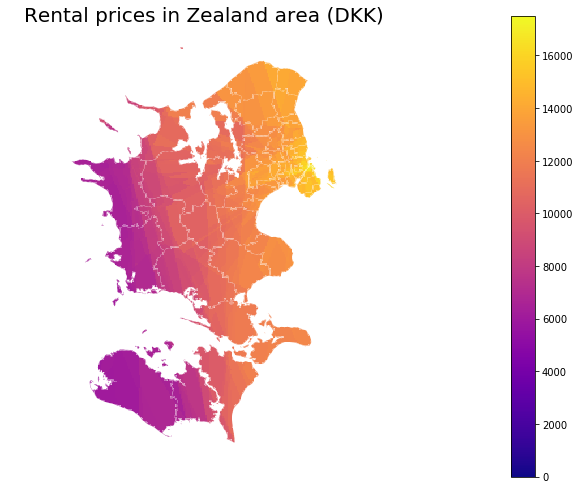

In [9]:
# Create map 
vmin, vmax = 0, 17500
ax = intersection.plot(column="interpolated_price", figsize=(11,8), vmin=vmin, vmax=vmax,cmap='plasma')

price_plot = ax.get_figure()

ax.set_title('Rental prices in Zealand area (DKK)' , fontsize=50)
ax.axis('off')

cax = price_plot.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

price_plot.colorbar(sm, cax=cax)

It is quite clear from the plot that (interpolated) house prices are a lot higher in CPH.

### Preparing the dataset for machine learning and setting up functions

In [68]:
# Copy data
ml_data = df.copy()

# One-hot encode nominal variables
ml_data = pd.get_dummies(ml_data, columns=["boligtype", "delevenlig", "etage", "husdyr_tilladt", "lejeperiode", "møbleret", "overtagelsesdato"], drop_first=True)

# Drop irrelevant columns
ml_data = ml_data.drop(["adresse", "oprettelsesdato"], axis=1)

# Drop Na's
ml_data = ml_data.dropna()

# Specify feature and label data
X = ml_data.drop(["månedlig_leje"], axis=1).values
y = ml_data["månedlig_leje"].values

# Print dataframe
ml_data.head()

,aconto,depositum,forudbetalt_leje,indflytningspris,månedlig_leje,størrelse,værelser,longitude,latitude,boligtype_Rækkehus,...,etage_7. sal,etage_8. sal,etage_kælderen,etage_stuen,husdyr_tilladt_Nej,lejeperiode_2+ år,lejeperiode_2-12 mdr.,lejeperiode_Ubegrænset,møbleret_Nej,overtagelsesdato_snarest
1,520.0,27600,9200.0,46520,9200,102,3,9.914872,57.050140,0,...,0,0,0,0,1,0,0,1,1,0
3,0.0,9300,0.0,12400,3100,70,3,8.320781,56.762740,0,...,0,0,0,0,0,0,0,1,1,1
4,880.0,22485,7495.0,38355,7495,95,3,9.937992,57.042563,0,...,0,0,0,0,1,0,0,1,1,1
5,600.0,17520,0.0,23960,5840,56,2,9.848209,55.863539,0,...,0,0,0,0,1,0,0,1,1,1
6,300.0,25701,25701.0,60269,8567,65,2,10.203933,56.152968,0,...,0,0,0,0,1,0,0,1,1,0


In [69]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def prediction_model(splits, model, X, y):
    
    # Set hyperparameters and empty vectors:
    kf = KFold(n_splits=int(splits), random_state=42)
    mse_score_train = []
    mse_score_test = []

    # Setup cross validation loop:
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]    
    
        model.fit(X_train, y_train) 
    
        y_pred = model.predict(X_train)
        mse_score_train.append(mean_squared_error(y_train, y_pred))

        y_pred1 = model.predict(X_test)
        mse_score_test.append(mean_squared_error(y_test, y_pred1))

    # Print the mean accuracy score across all 10 kfolds:
    print("Training RMSE score:", math.sqrt(np.mean(mse_score_train)))
    print("Testing RMSE score:", math.sqrt(np.mean(mse_score_test)))

### Running machine learning models

To begin with we need a baseline model to compare our other models to. Let's choose the simplest one: The mean of the rental prices.

In [70]:
import math

mean_rental = y.mean()

se_baseline = []
for i in y: 
    calc = (i-mean_rental)**2
    se_baseline.append(calc)
    
print("RMSE for baseline model (dumb mean):", math.sqrt(np.mean(se_baseline)))

RMSE for baseline model (dumb mean): 4812.399978001145


Now that we have a baseline to compare to we can run our ML-models. First, let us test a random forest regressor. They tend to perform quite well and be robust in a lot of different scenarios.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#Finding best hyperparameters through grid-search:
model = RandomForestRegressor()

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
random_search = RandomizedSearchCV(estimator = model, param_distributions = param_dist, cv=3, 
                                   n_iter = 100, scoring="mean_squared_error")

#Report best parameters
random_search.fit(X, y)
random_search.best_params_

In [71]:
# Initialize and test/train model
model = RandomForestRegressor()
prediction_model(10, model, X, y)

Training RMSE score: 510.52828739389014
Testing RMSE score: 1279.923811596377
